In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Phase_Retrieval/Conferencia/utils")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
from LoadData import DataGenerator
from AcquisitionLayer import Muestreo
#from InitializationLayer import FSI
from pruebas_layers import ProposedInitializationModelUnrolledWithUnet, customGaussian
#from FinalModel import ProposedInitializationModelUnrolled
from CallBacks import SaveResults_CBMNIST
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from loss_and_metrics import *
from scipy.io import savemat, loadmat

In [ ]:
BATCH_SIZE = 32
dim = (256,256)

RESULTS_DIR = "../results"

DATASET_DIR = "../DATASET"
lista_archivos = []
lista_archivos = lista_archivos+[ os.path.join(DATASET_DIR, "TRAIN", archivo) for archivo in os.listdir(os.path.join(DATASET_DIR, "TRAIN"))]
lista_archivos = lista_archivos+[ os.path.join(DATASET_DIR, "TEST", archivo) for archivo in os.listdir(os.path.join(DATASET_DIR, "TEST"))]
lista_archivos = lista_archivos+[ os.path.join(DATASET_DIR, "VALIDATION", archivo) for archivo in os.listdir(os.path.join(DATASET_DIR, "VALIDATION"))]
train_files, test_files = train_test_split(lista_archivos,test_size=0.2, random_state=42)
test_files, validation_files = train_test_split(test_files,test_size=0.5, random_state=42)



train_generator = DataGenerator(train_files, batch_size=BATCH_SIZE, dim=dim, shuffle=True)
test_generator = DataGenerator(test_files, batch_size=BATCH_SIZE, dim=dim, shuffle=False)
validation_generator = DataGenerator(validation_files, batch_size=BATCH_SIZE, dim=dim, shuffle=False)

#X = test_generator.__getitem__(6)[0]
# train_generator = DataGenerator(x_train, BATCH_SIZE, dim)
# test_generator = DataGenerator(x_test, BATCH_SIZE, dim)

In [ ]:
X = train_generator[0][0]


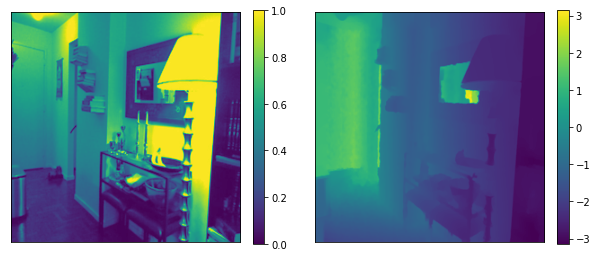

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
#fig.savefig(os.path.join(RESULTS_DIR, "basic", "imagen_real_pesos_aprendidos.svg"))
fig.show()

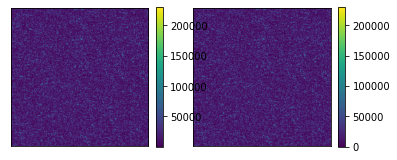

In [ ]:
conv_psf, _ = Muestreo(1)(X)
fig, axs = plt.subplots(1,2,figsize=(6,6))
a = axs[0].imshow(conv_psf[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)

muestras_ruido = customGaussian(60)(conv_psf)
a = axs[1].imshow(muestras_ruido[0,:,:,0])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])

fig.show()

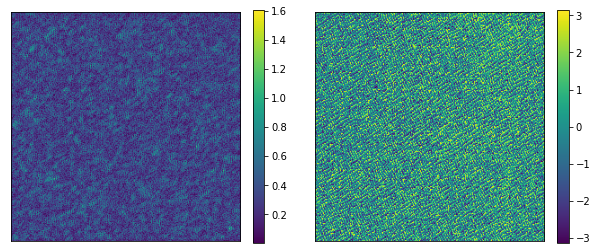

In [ ]:
modelo = ProposedInitializationModelUnrolledWithUnet(1, None, init = False, use_generator = True)

#model.load_weights(os.path.join(RESULTS_DIR, "SNR_None_last_weights.h5"))

inicializacion = modelo(X)
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(inicializacion[0][0,:,:]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(inicializacion[1][0,:,:])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()

In [ ]:
def sin_loss(y1,y2):
  mse = tf.keras.losses.MeanSquaredError()
  y1_sin = tf.math.sin(y1)
  y2_sin = tf.math.sin(y2)
  return mse(y1_sin,y2_sin)


  #return tf.keras.backend.mean(-tf.math.cos((y1-y2)/2)+1, axis = [1,2])
  #return mse(-tf.math.cos((y1-y2)/2)+1)

# def mse_dummy(y1,y2):
#   if tf.executing_eagerly():
#     tf.print(y1.numpy().min(), y1.numpy().max())
#     tf.print(y2.numpy().min(), y2.numpy().max())
#   mse = tf.keras.losses.MeanSquaredError()
    
  return mse(y1,y2)
# def exp_decay(epoch):
#    initial_lrate = 0.01
#    k = 0.25
#    lrate = initial_lrate * np.exp(-k*epoch)
#    return lrate
def run_train(n_epochs, results_dir,input_shape = (BATCH_SIZE, *(*dim,2)),train_generator = None, test_generator = None, SNR = 0, init = False, use_generator = True):
  
  mse = 'mean_squared_error'
  folder = os.path.join(results_dir)
  type_model = str(SNR)+"init_"+str(init)
  chekpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(folder, "SNR_"+type_model+"_last_weights.h5"), save_weights_only=True, monitor='val_loss', mode='max')
  save_results = SaveResults_CBMNIST(folder, generator = test_generator, type_model=type_model)


  opti = tf.keras.optimizers.Adam(learning_rate = 1e-3, amsgrad=True)#, momentum = 1e-9)
  model = ProposedInitializationModelUnrolledWithUnet(snapshots=1, SNR=SNR, use_generator=use_generator, init = init)
  model.build(input_shape) 

  #model.save_weights(os.path.join(folder,  "SNR_"+type_model+"_initial_weights.h5"))
  model.load_weights(os.path.join(folder, "SNR_"+type_model+"_last_weights.h5"))
  mse = tf.keras.losses.MeanSquaredError()
  #losses = [Loss_Abs, Loss_Ang, Loss_Abs, Loss_Ang,Loss_Abs, Loss_Ang, Loss_Abs, Loss_Ang,Loss_Abs, Loss_Ang]
  #losses = [mse, mse, Loss_Abs, Loss_Ang, mse, mse, mse, mse,mse, mse]
  #losses_w = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
  losses = [mse, sin_loss, mse, mse]#, mse, sin_loss, mse, sin_loss, mse, sin_loss]#, mse, sin_loss, mse, sin_loss, mse, sin_loss,mse, sin_loss]
  losses_w = np.array([0.1, 0.4, 0.3, 1.2])#, 0.2, 0.8 , 0.2, 0.8, 0.2, 0.8])
  model.compile(optimizer=opti, loss=losses, loss_weights=losses_w, run_eagerly=False)
  

  # layers_to_freeze = [3, 6,8,10,12,13]
  # for indx, layer in enumerate(model.layers):
  #   if indx in layers_to_freeze:
  #     layer.trainable = False

  print("Entrenamiento de la red: " +type_model)

  model.summary()
  history = model.fit(train_generator, epochs=n_epochs, batch_size=BATCH_SIZE, validation_data=test_generator,callbacks=[chekpoint, save_results])


  # model.layers[2].trainable = False
  # for indx, layer in enumerate(model.layers):
  #   if indx in layers_to_freeze:
  #     layer.trainable = True

  return model, history


In [ ]:
# TRAIN BASIC MODEL
EPOCHS = 250
tf.keras.backend.clear_session()
model, history = run_train(EPOCHS, results_dir = RESULTS_DIR, train_generator = train_generator, test_generator= test_generator, SNR=None, init = False, use_generator=True)

Entrenamiento de la red: Noneinit_False
Model: "proposed_initialization_model_unrolled_with_unet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MuestreoLayer (Muestreo)     multiple                  0         
_________________________________________________________________
init_initialzation (FSI_Init multiple                  0         
_________________________________________________________________
InitializationLayer (FSI_cel multiple                  50        
_________________________________________________________________
Unet_ABS (Unet)              multiple                  1359960   
_________________________________________________________________
Unet_ANG (Unet)              multiple                  1359960   
_________________________________________________________________
rescaling (Rescaling)        multiple                  0         
____________________________________________

In [ ]:
# # TRAIN BASIC MODEL

# tf.keras.backend.clear_session()
# model, history = run_train(EPOCHS, results_dir = RESULTS_DIR, train_generator = train_generator, test_generator= test_generator, SNR=10, init = False)

In [ ]:
# # TRAIN BASIC MODEL
# EPOCHS = 100
# model, history = run_train(EPOCHS, results_dir = RESULTS_DIR, train_generator = train_generator, test_generator= test_generator, SNR=20)

In [ ]:
# model, history = run_train(EPOCHS, results_dir = RESULTS_DIR, train_generator = train_generator, test_generator= test_generator, SNR=5)

In [ ]:
def plot_and_save_kernels(SNR, initials=False, init = False, use_generator = True):
  if initials:
    tipo = "initial"
  else: 
    tipo = "last"
  
  type_model = str(SNR)+"init_"+str(init)
  model = ProposedInitializationModelUnrolledWithUnet(snapshots=1, SNR=SNR, use_generator=use_generator, init = False)


  model.build( (BATCH_SIZE, *(*dim,2)))
  model.load_weights(os.path.join(RESULTS_DIR, "SNR_"+type_model+"_"+tipo+"_weights.h5"))
  fig, axs = plt.subplots(1, 2,figsize=(10,10))
  a = axs[0].imshow(model.get_weights()[0][:,:,0,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
  fig.colorbar(a, ax=axs[0],fraction=0.046)
  a = axs[1].imshow(model.get_weights()[1][:,:,0,0])
  fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
  fig.show()

  pesos = model.get_weights()

  filtro_real = tf.squeeze(pesos[0])
  filtro_imag = tf.squeeze(pesos[1])

  dict_kernel = {"kernel_real":filtro_real.numpy().tolist(),
                "kernel_imag":filtro_imag.numpy().tolist()}

  savemat(os.path.join(RESULTS_DIR, "SNR_"+type_model+"_Kernerls_Entrenados_"+tipo+".mat"), dict_kernel)

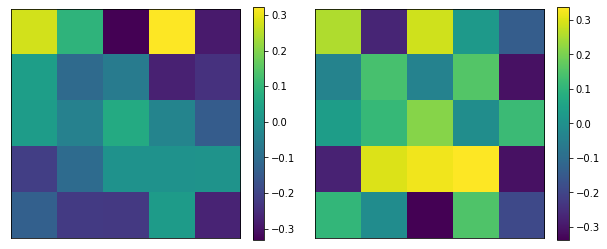

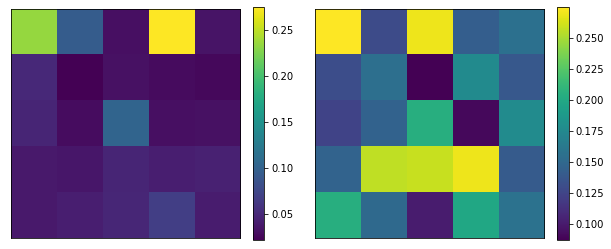

In [ ]:
plot_and_save_kernels(None, initials=True, init=False, use_generator = True)
plot_and_save_kernels(None, initials=False, init=False, use_generator = True)

In [ ]:
# plot_and_save_kernels(10, initials=True, init=False, use_generator = True)
# plot_and_save_kernels(10, initials=False, init=False, use_generator = True)

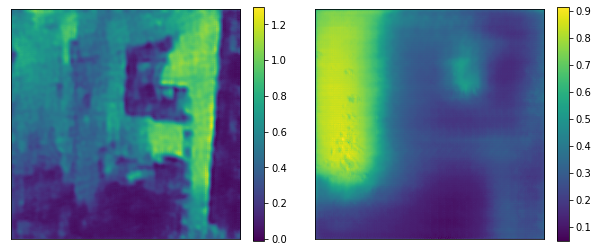

In [ ]:
pred = model(X)
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(pred[-2][0,:,:]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(pred[-1][0,:,:])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()